DatasetDict({
    train: Dataset({
        features: ['text_combined', 'label'],
        num_rows: 85782
    })
})
Dataset loaded: 85782 samples
Class distribution:
label
0    42891
1    42891
Name: count, dtype: int64



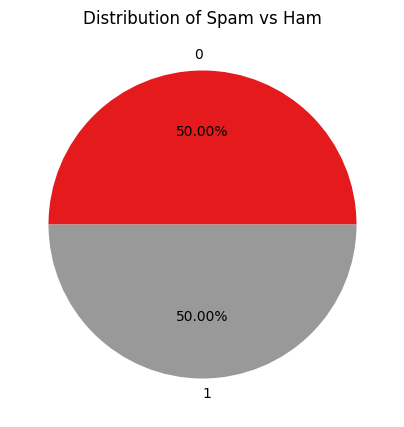

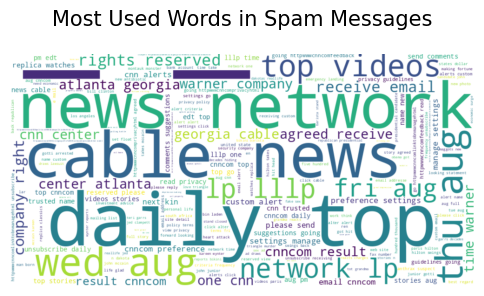

Normalization complete: 85777 samples remaining
 Train set: 60043 samples
  - Ham: 30023, Spam: 30020
 Validation set: 8578 samples
  - Ham: 4289, Spam: 4289
 Test set: 17156 samples
  - Ham: 8579, Spam: 8577


Map:   0%|          | 0/60043 [00:00<?, ? examples/s]

Map:   0%|          | 0/8578 [00:00<?, ? examples/s]

Map:   0%|          | 0/17156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 60043
    })
    validation: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8578
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 17156
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/60043 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8578 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17156 [00:00<?, ? examples/s]

In [17]:
# -*- coding: utf-8 -*-
"""Preprocessing.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1ZRAPMYH61qKE4p1Nv3pBI6N2awlUOS3T

**Libraries**
"""

# Commented out IPython magic to ensure Python compatibility.
#Libraries
import numpy as np
import pandas as pd
import re

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Word Cloud library
from wordcloud import WordCloud, STOPWORDS

# Library used for data preprocessing
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import AutoTokenizer

# Model selection libraries
from sklearn.model_selection import train_test_split

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

import os

# Define folder structure
base_dir = os.getcwd()  # current directory
data_dir = os.path.join(base_dir, "data")
models_dir = os.path.join(base_dir, "models")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

"""**Dataset Loading**"""

dataset = load_dataset("bourigue/data_email_spam")
print(dataset)

df = dataset['train'].to_pandas()
df.head()

print(f"Dataset loaded: {len(df)} samples")
print(f"Class distribution:\n{df['label'].value_counts()}\n")

"""**Dataset Visualization**"""

import matplotlib.pyplot as plt

# Label distribution
spread = df['label'].value_counts()

# Pie chart
plt.rcParams['figure.figsize'] = (5, 5)
spread.plot(kind='pie', autopct='%1.2f%%', cmap='Set1')
plt.title('Distribution of Spam vs Ham')
plt.ylabel('')
plt.show()

"""Word Cloud Visualization:"""

df_spam = df[df['label'] == 1]
stopwords = set(STOPWORDS)
text = " ".join(df_spam['text_combined'].astype(str).tolist()).lower()

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=stopwords,
    max_words=1000
).generate(text)

plt.figure(figsize=(6, 6))
plt.title("Most Used Words in Spam Messages", fontsize=15, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

"""**Preprocessing Dataset**"""

CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'train_split': 0.7,
    'val_split': 0.1,
    'test_split': 0.2,
    'seed': 42
}

# Normalization:

def normalize_text(text):
    #Normalizing and cleaning email text while preserving spam indicators

    if pd.isna(text):
        return ""

    text = str(text)

    #Lowercase
    text = text.lower()

    #Normalize repeated characters (such as "oooo " or "eeeee")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    #Normalize numbers and replace with NUMBER token
    text = re.sub(r'\d+', ' NUMBER ', text)

    #Normalize currency symbols
    text = re.sub(r'[$£€¥₹]', ' CURRENCY ', text)

    #Replace URLs with URL token
    text = re.sub(r'http\S+|www\.\S+', ' URL ', text)

    #Replace email addresses with EMAIL token
    text = re.sub(r'\S+@\S+', ' EMAIL ', text)

    #Normalize excessive punctuation
    text = re.sub(r'!{2,}', ' EXCLAMATION ', text)
    text = re.sub(r'\?{2,}', ' QUESTION ', text)

    #Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    #Remove special characters
    text = re.sub(r'[^\w\s!?$]', ' ', text)

    #Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #Remove very short texts
    if len(text) < 10:
        return ""

    return text

df['text_combined'] = df['text_combined'].apply(normalize_text)

# Remove empty texts after normalization
df = df[df['text_combined'].str.len() > 0].reset_index(drop=True)
print(f"Normalization complete: {len(df)} samples remaining")

## save the cleaned dataset (for TF-IDF models) !!! put in gitignore
cleaned_path = os.path.join(data_dir, "cleaned_spam_dataset.csv")
df.to_csv(cleaned_path, index=False)

"""**Splitting dataset**"""

#Test set:
train_val_df, test_df = train_test_split(
    df,
    test_size=CONFIG['test_split'],
    random_state=CONFIG['seed'],
    stratify=df['label']
)

#Validation set from training set:
val_size = CONFIG['val_split'] / (CONFIG['train_split'] + CONFIG['val_split'])
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    random_state=CONFIG['seed'],
    stratify=train_val_df['label']
)

print(f" Train set: {len(train_df)} samples")
print(f"  - Ham: {(train_df['label']==0).sum()}, Spam: {(train_df['label']==1).sum()}")
print(f" Validation set: {len(val_df)} samples")
print(f"  - Ham: {(val_df['label']==0).sum()}, Spam: {(val_df['label']==1).sum()}")
print(f" Test set: {len(test_df)} samples")
print(f"  - Ham: {(test_df['label']==0).sum()}, Spam: {(test_df['label']==1).sum()}")

## save individual splits for consistency
train_path = os.path.join(data_dir, "train_split.csv")
val_path   = os.path.join(data_dir, "val_split.csv")
test_path  = os.path.join(data_dir, "test_split.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

"""**Tokenization**"""

def tokenize_function(examples):

    tokens = tokenizer(
        examples['text_combined'],
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    tokens['labels'] = examples['label']
    return tokens

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

train_dataset = Dataset.from_pandas(train_df[['text_combined', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text_combined', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_combined', 'label']])

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text_combined', 'label'])

#Final Dataset:
final_dataset = DatasetDict({'train': tokenized_train, 'validation': tokenized_val,'test': tokenized_test})

print(final_dataset)

## Save the tokenized dataset (for transformers)
tokenized_path = os.path.join(data_dir, "tokenized_dataset")
final_dataset.save_to_disk(tokenized_path)

In [19]:
"""
bert-based spam classification model
fine-tunes a pretrained bert model for spam detection using email text data
loads preprocessed tokenized dataset, trains and evaluates the model,
and saves the trained model, tokenizer, and metrics to /src/models
"""

import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import load_from_disk
import warnings
warnings.filterwarnings("ignore")

# set base paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data", "tokenized_dataset")
MODEL_DIR = os.path.join(BASE_DIR, "src", "models", "final_bert_spam_classifier")
LOG_DIR = os.path.join(BASE_DIR, "src", "logs")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# load tokenized dataset
print("loading tokenized dataset...")
final_dataset = load_from_disk(DATA_DIR)
print(f"dataset loaded with splits: {list(final_dataset.keys())}")

# convert dataset to torch tensors
final_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# load pretrained bert tokenizer and model
print("loading pretrained bert model...")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# training configuration
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_dir=LOG_DIR,
    logging_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none"
)

# trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train model
print("starting training...")
trainer.train()
print("training complete.")

# evaluate on test set
print("evaluating on test set...")
results = trainer.evaluate(final_dataset["test"])
print("evaluation results:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

# save model and tokenizer
print("saving model and tokenizer...")
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"model saved to {MODEL_DIR}")

# save metrics
metrics_path = os.path.join(MODEL_DIR, "bert_results.csv")
pd.DataFrame([results]).to_csv(metrics_path, index=False)
print(f"metrics saved to {metrics_path}")

print("bert model training complete.")


loading tokenized dataset...
dataset loaded with splits: ['train', 'validation', 'test']
loading pretrained bert model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


starting training...


Step,Training Loss
500,0.132800
1000,0.057600
1500,0.042300
2000,0.031500
2500,0.011200
3000,0.011000
3500,0.011700


training complete.
evaluating on test set...


evaluation results:
eval_loss: 0.0311
eval_accuracy: 0.9922
eval_precision: 0.9938
eval_recall: 0.9907
eval_f1: 0.9922
eval_runtime: 29.6942
eval_samples_per_second: 577.7560
eval_steps_per_second: 9.0590
epoch: 2.0000
saving model and tokenizer...
model saved to /content/src/models/final_bert_spam_classifier
metrics saved to /content/src/models/final_bert_spam_classifier/bert_results.csv
bert model training complete.


In [20]:
"""
distilbert-based spam classification model
fine-tunes a pretrained distilbert model for spam detection using email text data
loads preprocessed tokenized dataset, trains and evaluates the model,
and saves the trained model, tokenizer, and metrics to /src/models
"""

import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import load_from_disk
import warnings
warnings.filterwarnings("ignore")

# set base paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data", "tokenized_dataset")
MODEL_DIR = os.path.join(BASE_DIR, "src", "models", "final_distilbert_spam_classifier")
LOG_DIR = os.path.join(BASE_DIR, "src", "logs")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# load tokenized dataset
print("loading tokenized dataset...")
final_dataset = load_from_disk(DATA_DIR)
print(f"dataset loaded with splits: {list(final_dataset.keys())}")

# convert dataset to torch tensors
final_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# load pretrained distilbert tokenizer and model
print("loading pretrained distilbert model...")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# training configuration
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,  # slightly higher than BERT (DistilBERT trains faster)
    weight_decay=0.01,
    logging_dir=LOG_DIR,
    logging_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none"
)

# trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train model
print("starting training...")
trainer.train()
print("training complete.")

# evaluate on test set
print("evaluating on test set...")
results = trainer.evaluate(final_dataset["test"])
print("evaluation results:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

# save model and tokenizer
print("saving model and tokenizer...")
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"model saved to {MODEL_DIR}")

# save metrics
metrics_path = os.path.join(MODEL_DIR, "distilbert_results.csv")
pd.DataFrame([results]).to_csv(metrics_path, index=False)
print(f"metrics saved to {metrics_path}")

print("distilbert model training complete.")


loading tokenized dataset...
dataset loaded with splits: ['train', 'validation', 'test']
loading pretrained distilbert model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


starting training...


Step,Training Loss
500,0.124400
1000,0.055500
1500,0.044000
2000,0.028600
2500,0.013700
3000,0.008300
3500,0.007900


training complete.
evaluating on test set...


evaluation results:
eval_loss: 0.0299
eval_accuracy: 0.9929
eval_precision: 0.9940
eval_recall: 0.9917
eval_f1: 0.9929
eval_runtime: 19.5197
eval_samples_per_second: 878.9050
eval_steps_per_second: 13.7810
epoch: 2.0000
saving model and tokenizer...
model saved to /content/src/models/final_distilbert_spam_classifier
metrics saved to /content/src/models/final_distilbert_spam_classifier/distilbert_results.csv
distilbert model training complete.


In [21]:
from google.colab import files
import shutil

# Create zipped copies for download
shutil.make_archive("bert_model", "zip", "src/models/final_bert_spam_classifier")
shutil.make_archive("distilbert_model", "zip", "src/models/final_distilbert_spam_classifier")

# Download the zip files
files.download("bert_model.zip")
files.download("distilbert_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
"""
utility script to evaluate a trained spam classification model on new text samples
loads a saved bert or distilbert model from disk, predicts labels for given inputs,
and saves the results to /src/results or specified output path
"""

import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(model_path, texts):
    """
    loads a trained model and predicts spam/ham labels for given text inputs

    Args:
        model_path (str): path to the saved model directory
        texts (list): list of text strings to evaluate

    Returns:
        pd.DataFrame: dataframe containing texts and their predicted labels
    """

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # tokenize input texts
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    ).to(device)

    # make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # map predictions to labels
    labels = ["HAM" if p == 0 else "SPAM" for p in predictions]

    # return as dataframe
    return pd.DataFrame({"text": texts, "prediction": labels})


def save_results(results_df, output_path):
    """
    saves prediction results to a CSV file

    Args:
        results_df (pd.DataFrame): dataframe with 'text' and 'prediction' columns
        output_path (str): path to save the CSV file
    """

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to: {output_path}")



if __name__ == "__main__":
    # path to trained model (update as needed)
    MODEL_PATH = "src/models/final_bert_spam_classifier"
    OUTPUT_PATH = "src/evaluate/results/bert_predictions.csv"


    sample_texts = [
        "Congratulations! You have won a $1000 gift card. Click here to claim it.",
        "Hey Sarah, just checking if you're free for dinner tomorrow.",
        "Your bank account is on hold. Verify your details immediately.",
        "Please find attached the latest meeting notes."
    ]

    # evaluate and save
    results = evaluate_model(MODEL_PATH, sample_texts)
    print(results)
    save_results(results, OUTPUT_PATH)


                                                text prediction
0  Congratulations! You have won a $1000 gift car...       SPAM
1  Hey Sarah, just checking if you're free for di...        HAM
2  Your bank account is on hold. Verify your deta...       SPAM
3     Please find attached the latest meeting notes.        HAM
Results saved to: src/evaluate/results/bert_predictions.csv


In [23]:
"""
utility script to evaluate a trained spam classification model on new text samples
loads a saved bert or distilbert model from disk, predicts labels for given inputs,
and saves the results to /src/results or specified output path
"""

import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(model_path, texts):
    """
    loads a trained model and predicts spam/ham labels for given text inputs

    Args:
        model_path (str): path to the saved model directory
        texts (list): list of text strings to evaluate

    Returns:
        pd.DataFrame: dataframe containing texts and their predicted labels
    """

    # load tokenizer and model (Auto classes handle both BERT and DistilBERT)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval()

    # tokenize input texts
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=128
    ).to(device)

    # make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

    # map predictions to labels
    labels = ["HAM" if p == 0 else "SPAM" for p in predictions]

    # return as dataframe
    return pd.DataFrame({"text": texts, "prediction": labels})


def save_results(results_df, output_path):
    """
    saves prediction results to a CSV file

    Args:
        results_df (pd.DataFrame): dataframe with 'text' and 'prediction' columns
        output_path (str): path to save the CSV file
    """

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to: {output_path}")


# example usage
if __name__ == "__main__":
    # path to trained model (update as needed)
    MODEL_PATH = "src/models/final_distilbert_spam_classifier"
    OUTPUT_PATH = "src/evaluate/results/distill_bert_predictions.csv"

    # sample inputs
    sample_texts = [
        "Congratulations! You have won a $1000 gift card. Click here to claim it.",
        "Hey Sarah, just checking if you're free for dinner tomorrow.",
        "Your bank account is on hold. Verify your details immediately.",
        "Please find attached the latest meeting notes."
    ]

    # evaluate and save
    results = evaluate_model(MODEL_PATH, sample_texts)
    print(results)
    save_results(results, OUTPUT_PATH)

                                                text prediction
0  Congratulations! You have won a $1000 gift car...       SPAM
1  Hey Sarah, just checking if you're free for di...        HAM
2  Your bank account is on hold. Verify your deta...       SPAM
3     Please find attached the latest meeting notes.        HAM
Results saved to: src/evaluate/results/distill_bert_predictions.csv
